In [1]:
# ! wget https://www.dropbox.com/s/7mcxjmxt1wfzybt/mnist_png.tar.bz2?dl=0 -O mnist_png.tar.bz
# ! tar -jxvf mnist_png.tar.bz    

In [2]:
import tensorflow as tf
import numpy as np
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.04, interpolation='bilinear', seed=42), # 15°  2pi * 0.04 -> rad
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,  # %
                                                                 width_factor=0.2,
                                                                 interpolation='nearest'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1,
                                                          width_factor=0.1,
                                                          interpolation='nearest')
])

In [4]:
inputs = tf.keras.Input(shape=(28,28,3)) 
x = data_augmentation(inputs)
x = tf.keras.layers.Conv2D(32, (3,3))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(32, (3,3))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(64, (3,3))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(64, (3,3))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(10)(x)
x = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.Model(inputs, x)

In [5]:
# model.summary()

In [6]:
# error on .fit()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               warning
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [9]:
train_dir = 'mnist_png/training/'
validation_dir = 'mnist_png/testing/'
# train_dir = 'mnist_png/training/'
# validation_dir = 'mnist_png/testing/'

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (28, 28)

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

Found 60000 files belonging to 10 classes.


In [12]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                         shuffle=True,
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMG_SIZE)

Found 10000 files belonging to 10 classes.


In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # better than val_acc
                                               patience=3, 
                                               verbose=2)

In [14]:
class_names = train_dataset.class_names

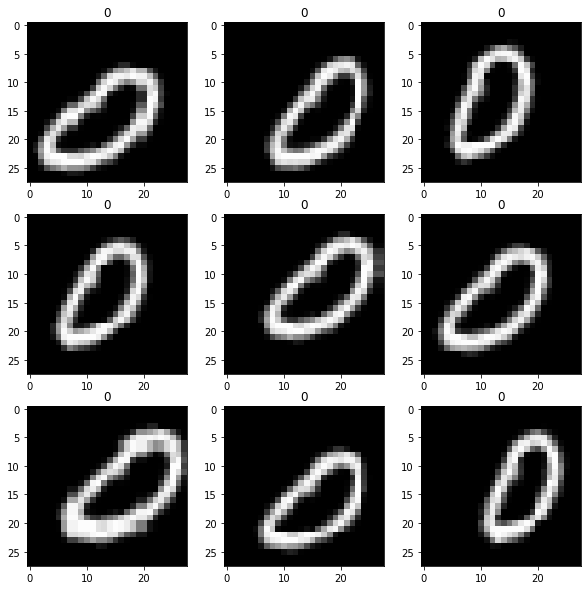

In [15]:
for image, labs in train_dataset.take(1): # image.shape=32
    first_img = image[0]
    plt.figure(figsize=(4,3))
    plt.imshow(first_img / 255)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        augm_img = data_augmentation(np.expand_dims(first_img, 0))
        plt.imshow(augm_img[0] / 255)
        plt.title(class_names[labs[0]])

In [16]:
len(validation_dataset)

313

In [17]:
history = model.fit(train_dataset,
                 epochs=60,
                 validation_data=validation_dataset,
                 callbacks=[es_callback])    

Epoch 1/60
1875/1875 [==============================] - 29s 14ms/step - loss: 0.3672 - accuracy: 0.8990 - val_loss: 0.0843 - val_accuracy: 0.9731
Epoch 2/60
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1197 - accuracy: 0.9641 - val_loss: 0.0382 - val_accuracy: 0.9886
Epoch 3/60
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1029 - accuracy: 0.9700 - val_loss: 0.0410 - val_accuracy: 0.9881
Epoch 4/60
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0955 - accuracy: 0.9724 - val_loss: 0.0504 - val_accuracy: 0.9858
Epoch 5/60
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0863 - accuracy: 0.9744 - val_loss: 0.0433 - val_accuracy: 0.9868
Epoch 00005: early stopping


In [18]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

In [19]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
model.save('es_func_exp.h5')